### **Digital Bookshelf Try #1.5: Throwing more out-of-the-box OCR systems at my problem**

After [limited success](https://github.com/davisrbr/bookRecognition/blob/master/notebooks/Traditional_Image_Processing.ipynb) with my previous attempt with Google's Tesseract OCR, I've decided to throw more out-of-the-box optical character recognition systems at the pre-delineated books and see which performs best. The biggest takeaway from this notebook is that pretty good OCR systems are now abundantly available.  

### First attempt: Easy OCR 
I'm first going to try [Jaided AI's Easy OCR](https://github.com/JaidedAI/EasyOCR). 

_Note: the model did not download for me, I had to grab the .pth file from [here](https://drive.google.com/file/d/1tdItXPoFFeKBtkxb9HBYdBGo-SyMg1m0/view)_.

In [1]:
# imports, path management
import matplotlib.pyplot as plt
import sys
import os 


sys.path.append(os.path.abspath(os.path.join('..', 'utils')))

I ended up pulling the matplotlib plots and pre-processing (i.e. deskewing, gray scaling, etc.) [into the function](https://github.com/davisrbr/bookRecognition/blob/master/utils) `plot_ocr`.

In [2]:
from plot_utils import plot_ocr
import easyocr
reader = easyocr.Reader(['en'], gpu = False)

Using CPU. Note: This module is much faster with a GPU.


CPU times: user 4min 25s, sys: 9.06 s, total: 4min 34s
Wall time: 2min 59s


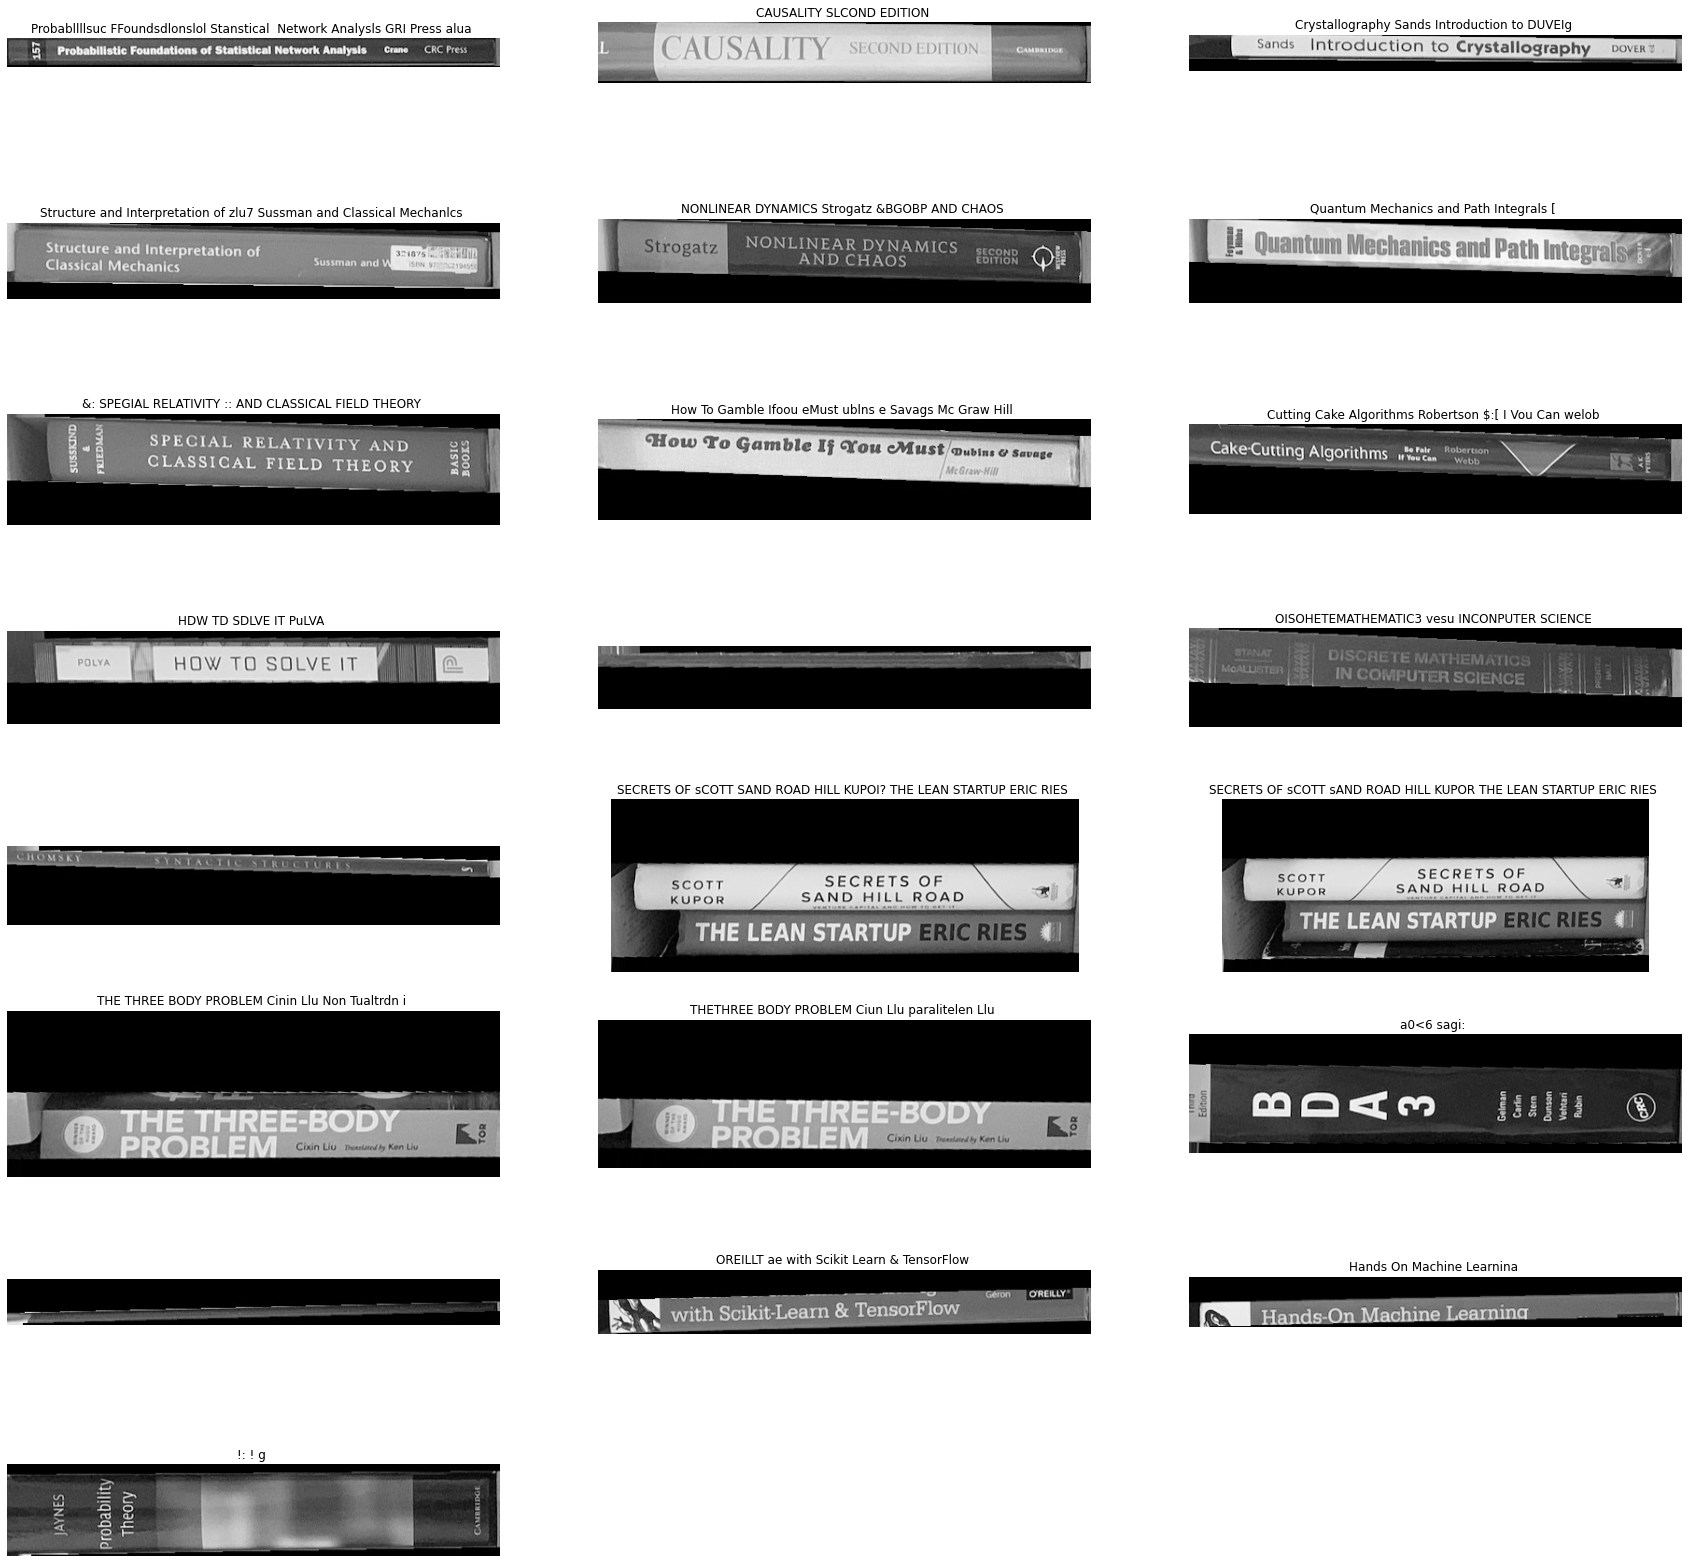

In [3]:
%%time
figure, axes = plot_ocr('../filteredbooks_CV/', 
                        reader.readtext,
                        gray=True,
                        deskew=True)

This performance was significantly better than my [last attempt!](https://github.com/davisrbr/bookRecognition/blob/master/notebooks/Traditional_Image_Processing.ipynb) The backbone algorithm is called [CRAFT, from this paper](https://arxiv.org/pdf/1904.01941.pdf). CRAFT uses character level detection. The paper uses a relatively clever approach where they do weakly-supervised learning for individual characters leveraged from datasets with word-level annotations. 

With some high powered regex and better delineation of the books, I suspect I will be able to identify all of these book titles + authors from a database. 

### Second attempt: keras-ocr
I'm still not happy with the speed (although I could make increase speed by ONNX-ing the PyTorch model behind Easy OCR. Or still, I could run it on a GPU). The [keras-ocr library](https://github.com/faustomorales/keras-ocr) also implements CRAFT in Keras/TensorFlow. I try out the performance of this library next.

In [4]:
import keras_ocr
import os
import matplotlib.pyplot as plt
from plot_utils import drawAnnotations

pipeline = keras_ocr.pipeline.Pipeline()
images = [keras_ocr.tools.read(os.path.join('../filteredbooks_CV/', file)) 
          for file in os.listdir('../filteredbooks_CV/')
          if str(file)[0] != '.'
         ]

Looking for /Users/davisbrown/.keras-ocr/craft_mlt_25k.h5
Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
Looking for /Users/davisbrown/.keras-ocr/crnn_kurapan.h5


I use the keras-ocr plotting function below (which is a bit more cluttered than my plotting function for multiple images). 

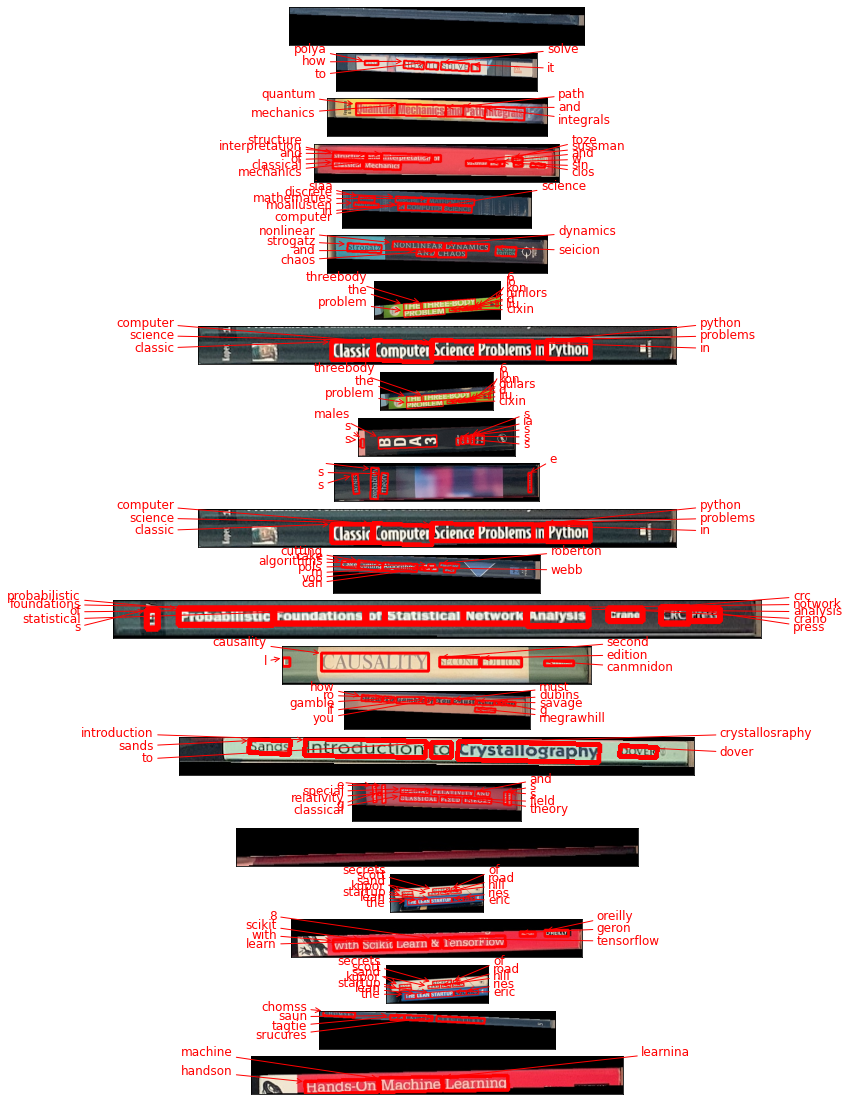

CPU times: user 6min 16s, sys: 26.6 s, total: 6min 42s
Wall time: 1min 9s


In [5]:
%%time
predictions = pipeline.recognize(images)
# Plot the predictions
fig, axs = plt.subplots(nrows=len(images), figsize=(20, 20))
for ax, image, predictions in zip(axs, images, predictions):
    drawAnnotations(image=image, predictions=predictions, ax=ax)
plt.show()

This attempt is nearly 3x faster (wall time) and qualitatively as accurate (although I'll have to test much more to be sure). It still struggles with vertical book titles, namely [Probability Theory by  Jaynes](https://www.amazon.com/Probability-Theory-Science-T-Jaynes/dp/0521592712)-- which will be, I suspect, trivially easy to fix with a rotation; it also missed on [BDA3](https://www.amazon.com/Bayesian-Analysis-Chapman-Statistical-Science/dp/1439840954).